In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#Import spectral libraries

In [2]:
from spectral.io import envi

# Ice
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.ice.filled.hdr"
ice = envi.open(fili)

# Ponds
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.pond.filled.hdr"
pond = envi.open(fili)

# Leads
fili = "C:/Users/apbarret/Documents/data/Sheba2/Sheba.SpectralLibrary.lead.filled.hdr"
lead = envi.open(fili)


#Import MODIS spectral response functions

In [3]:
from seaice_albedo_utilities import modis_srf, modis_bbalbedo
wv, srf = modis_srf()

Convert spectral albedos into modis broad band albedos and put into a pandas data frame

In [4]:
def spectra2modis(specLib, code=None):
    
    from seaice_albedo_utilities import modis_srf, modis_bbalbedo
    import re
    import datetime as dt
    
    # Parse spectra names
    sftype_ptrn = re.compile('^\w+ ')
    trgt_ptrn = re.compile('(?<=\[)(\w+ *){0,}')
    date_ptrn = re.compile('(\d{8})')
    sftype = [sftype_ptrn.search(a).group(0) for a in specLib.names]
    target = [trgt_ptrn.search(a).group(0) for a in specLib.names]
    date = [dt.datetime.strptime(date_ptrn.search(a).group(0),'%Y%m%d') for a in specLib.names]
    
    # put into a pandas dataframe
    import pandas as pd
    df = pd.DataFrame({'sftype': sftype, 'target': target, 'date': date, 'code':code})
    
    # Calculate band albedos
    df['band1'] = [modis_bbalbedo(specLib.bands.centers, specLib.spectra[i,:], wv, srf[0]) for i in np.arange(0,specLib.spectra.shape[0])] 
    df['band2'] = [modis_bbalbedo(specLib.bands.centers, specLib.spectra[i,:], wv, srf[1]) for i in np.arange(0,specLib.spectra.shape[0])] 
    df['band3'] = [modis_bbalbedo(specLib.bands.centers, specLib.spectra[i,:], wv, srf[2]) for i in np.arange(0,specLib.spectra.shape[0])] 
    df['band4'] = [modis_bbalbedo(specLib.bands.centers, specLib.spectra[i,:], wv, srf[3]) for i in np.arange(0,specLib.spectra.shape[0])]
    
    return df

In [5]:
ice_df = spectra2modis(ice, code='I')
pond_df = spectra2modis(pond, code='P')
lead_df = spectra2modis(lead, code='L')

Split pond into light, dark and with ice sub-types 

In [7]:
import pandas as pd

pond_df['subtype'] = 'Melt Pond'
pond_df['subtype'].loc[pond_df['target'].str.contains('Light')] = 'Light Pond'
pond_df['subtype'].loc[pond_df['target'].str.contains('Dark')] = 'Dark Pond'
pond_df['subtype'].loc[pond_df['target'].str.contains('frazil|brash')] = 'Icey Pond'

alldf = pd.concat([ice_df, pond_df, lead_df])
#alldf

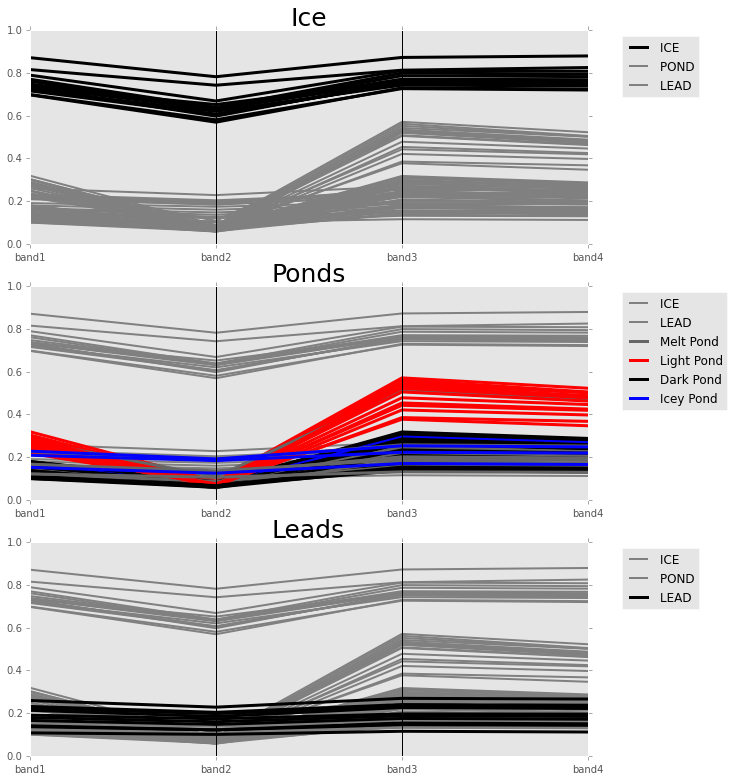

In [18]:
from pandas.tools.plotting import parallel_coordinates
matplotlib.style.use('ggplot')

f, ax = plt.subplots(3,1, figsize=(10, 13))
parallel_coordinates(ice_df, 'sftype', cols=['band1','band2','band3','band4'], color=['k'], lw=3, ax=ax[0])
parallel_coordinates(pond_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[0])
parallel_coordinates(lead_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[0])
ax[0].set_ylim(0,1.0)
ax[0].xaxis.label.set_size(30)
ax[0].set_title("Ice", fontsize=25)
lgd0 = ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2)

parallel_coordinates(ice_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[1])
parallel_coordinates(lead_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[1])
parallel_coordinates(pond_df, 'subtype', cols=['band1','band2','band3','band4'], color=['0.4','red','k','blue'], lw=3, ax=ax[1])
ax[1].set_ylim(0,1.0)
ax[1].set_title("Ponds", fontsize=25)
#ax[1].legend_.remove()
lgd1 = ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2)

parallel_coordinates(ice_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[2])
parallel_coordinates(pond_df, 'sftype', cols=['band1','band2','band3','band4'], color=['grey'], lw=2, ax=ax[2])
parallel_coordinates(lead_df, 'sftype', cols=['band1','band2','band3','band4'], color=['k'], lw=3, ax=ax[2])
ax[2].set_ylim(0,1.0)
ax[2].set_title("Leads", fontsize=25)
#ax[2].legend_.remove()
lgd2 = ax[2].legend(bbox_to_anchor=(1.05, 1), loc=2)

f.savefig('C:/Users/apbarret/Documents/Posters/AGU_Fall_2016_Barrett_Stroeve/sheba_modis_bands_for_agu2016.png', 
          bbox_extra_artists=(lgd0, lgd1, lgd2,), bbox_inches='tight')